In [1]:
from __future__ import division, print_function

In [2]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## A simple Metropolis MCMC

In this exercise, we'll implement the simplest MCMC algorithm and sample from a two-dimensional Gaussian to demonstrate the method. 

First, implement the probability distribution as a function that takes in a 2-D vector $\theta$ and returns:

$$
\ln p = -\frac{1}{2}\,\theta^\mbox{T}\,\Sigma^{-1}\,\theta + \mbox{constant}
$$

where

$$
\Sigma = \left(\begin{array}{cc}
1.0 & -0.08 \\
-0.08 & 0.01 \\
\end{array}\right)
$$

Note: you definitely want to compute $\ln p$ (not just $p$). Why?

In [4]:
Sigma = np.array([[1.0, -0.08], [-0.08, 0.01]])
def log_p_func(theta):
    return -0.5 * np.dot(theta, np.linalg.solve(Sigma, theta))

Next, implement the basic MCMC algorithm described here in words:

1. Initialize the parameters as $\theta(t=0)$.
2. Propose an update $q = \theta(t) + \sigma\,\delta$ where $\sigma$ is a tuning parameter and $\delta$ is drawn from a zero mean, unit variance Gaussian. Alternatively, you can try changing only one dimension.
3. Compute the acceptance probability $r = \mbox{min}\left(1,\,\frac{p(q)}{p(\theta(t))}\right)$.
4. Draw $u$ from a uniform distribution between 0 and 1. If $u < r$, accept the proposal and set $\theta(t+1) = q$ to the chain. Otherwise, reject the proposal and set $\theta(t+1) = \theta(t)$. Append $\theta(t+1)$ to the chain.
5. Go to step 2 and repeat.

A few notes:

- Throughout this function, it might be useful to track the acceptance fraction. Keep track of how many proposals you accept.
- Don't compute or use $p(\theta)$ directly – you should only ever use the logarithm of this function.
- Your implementation should support _vector_ parameters. For this problem, we'll be working in 2-D but don't special case to that because it might be useful to be able to sample more parameters later :-)

In [5]:
def mh(log_p_func, theta0, niter, sigma=0.1):
    ndim = len(theta0)
    theta = np.array(theta0)
    chain = np.empty((niter, ndim))
    lp = log_p_func(theta0)
    acc = 0
    for i in range(niter):
        q = np.array(theta)
        ind = np.random.randint(ndim)
        q[ind] += sigma * np.random.randn()
        lq = log_p_func(q)
        
        u = np.log(np.random.rand())
        if u < lq - lp:
            theta = q
            lp = lq
            acc += 1
        
        chain[i] = theta
        
    print("Acceptance fraction: {0:.3f}".format(acc / niter))
        
    return chain

Test this method on the log probability function that you implemented above. Initialize somewhere reasonable and run for $2\times10^6$ steps.

In [6]:
chain = mh(log_p_func, np.random.randn(2), 200000)

Acceptance fraction: 0.754


Plot the "trace" for each parameter:

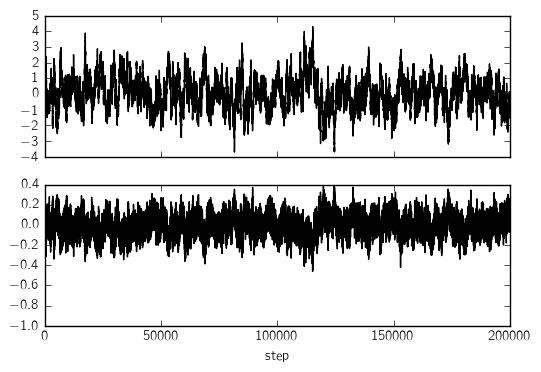

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(chain[:, 0], "k")
axes[1].plot(chain[:, 1], "k")
axes[1].set_xlabel("step");

Plot the samples in 2-D to see a representation of the probability distribution:

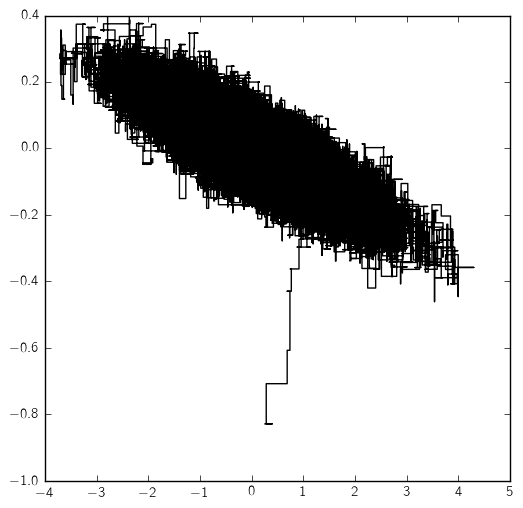

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(chain[:, 0], chain[:, 1], "k");

## Convergence

Implement a funtion to compute the autocorrelation function. This should take in a one-dimensional chain and return a different autocorrelation function for each parameter. You probably shouldn't compute this using a direct sum – it will be too slow! – [try using a fast Fourier transform](https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation).

In [9]:
def acorfn(x):
    n = len(x)
    f = np.fft.rfft(x - np.mean(x), n=2*n)
    acf = np.fft.irfft(f * np.conjugate(f))[:n].real
    return acf / acf[0]

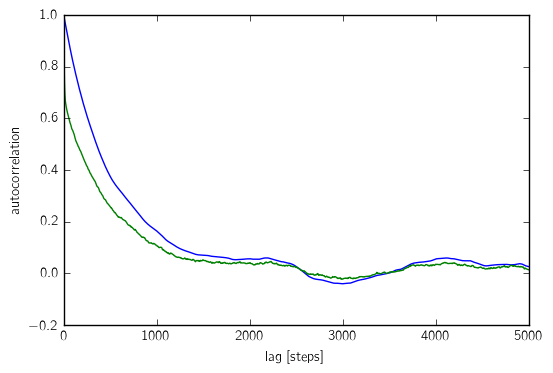

In [10]:
plt.plot(acorfn(chain[:, 0]))
plt.plot(acorfn(chain[:, 1]))
plt.xlim(0, 5000)
plt.xlabel("lag [steps]")
plt.ylabel("autocorrelation");

Read the suggested heuristic method for computing autocorelation times from pages 15-16 of [this note](http://www.stat.unc.edu/faculty/cji/Sokal.pdf) and implement 

In [11]:
def autocorr_time_simple(acf, window):
    return 1 + 2 * np.sum(acf[1:window])

def autocorr_time_iterative(acf, c=10, low=10):
    high = int(len(acf) / c)
    for M in np.arange(low, high).astype(int):
        tau = autocorr_time_simple(acf, M)
        if tau > 1.0 and M > c * tau:
            return tau
    raise RuntimeError("chain too short to estimate tau reliably")
    
print(autocorr_time_iterative(acorfn(chain[:, 0])), autocorr_time_iterative(acorfn(chain[:, 1])))

940.750624327 733.19511945


## Tuning & troubleshooting

Now go back and try changing the value of $\sigma$ in the proposal to see if you can find a better setting (i.e. a value where the autocorrelation time is shorter). What about using a different $\sigma$ for each dimension? What happens when you choose extreme values of $\sigma$ and "break" the sampler?

## A more realistic example

Now, let's try fitting a line to data. Load the dataset that I generated in advance:

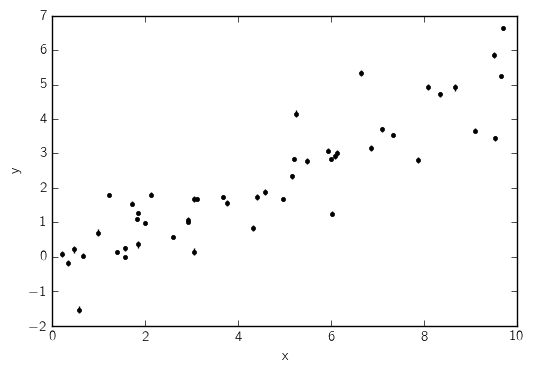

In [15]:
x, y, yerr = np.loadtxt("data.txt", unpack=True)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y");

The model that we'll use in this case is a linear model with a "jitter" term. In this model, the likelihood is:

$$
\ln p (y\,|\,m,\,b,\,s) = -\frac{1}{2} \sum_{n=1}^N\left[ \left(\frac{y_n-m\,x_n-b}{\sigma^2 + e^{s}}\right)^2 + \ln(2\,\pi\,(\sigma^2 + e^{s}))\right]
$$

and the prior is:

$$
\ln p(m,\,b,\,s) \propto -\frac{3}{2}\ln(1+b^2)
$$

(see [this blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) for more details about this choice of prior).

Implement this model in code:

In [17]:
def log_prior(m, b, s):
    return -1.5 * np.log(1 + b**2)

def log_likelihood(m, b, s):
    mod = m * x + b
    var = np.sqrt(yerr**2 + np.exp(s))
    return -0.5 * np.sum((y-mod)**2/var + np.log(var))

def log_posterior(theta):
    return log_prior(*theta) + log_likelihood(*theta)

And use your implementation of Metropolis to sample from this posterior probability.

In [18]:
line_chain = mh(log_posterior, np.random.randn(3), 200000)

Acceptance fraction: 0.640


Plot the traces:

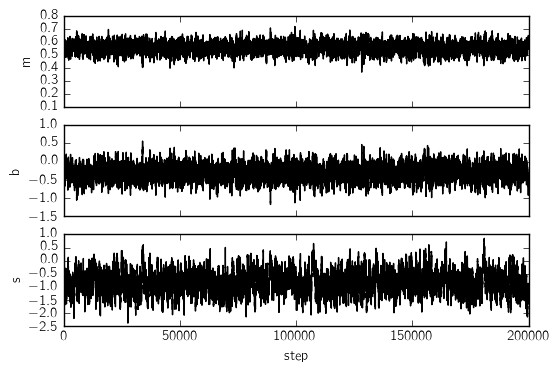

In [22]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(line_chain[:, 0], "k")
axes[0].set_ylabel("m")
axes[1].plot(line_chain[:, 1], "k")
axes[1].set_ylabel("b")
axes[2].plot(line_chain[:, 2], "k")
axes[2].set_ylabel("s")
axes[2].set_xlabel("step");

And the [corner plot](http://corner.readthedocs.io/):

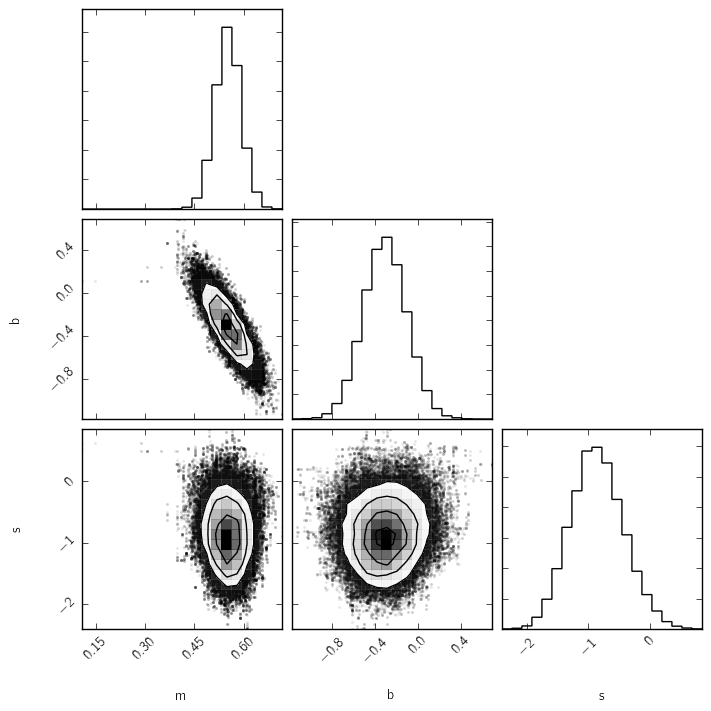

In [23]:
import corner
corner.corner(line_chain, labels=["m", "b", "s"]);

Compute the autocorrelation times:

In [26]:
print(autocorr_time_iterative(acorfn(line_chain[:, 0])),
      autocorr_time_iterative(acorfn(line_chain[:, 1])),
      autocorr_time_iterative(acorfn(line_chain[:, 2])))

127.306573702 130.870998072 345.570526504


Finally, plot the posterior prediction of the model in the data space. The best way to do this is to overplot the predicted line for several samples from the posterior on the data. Here is what it might look like:

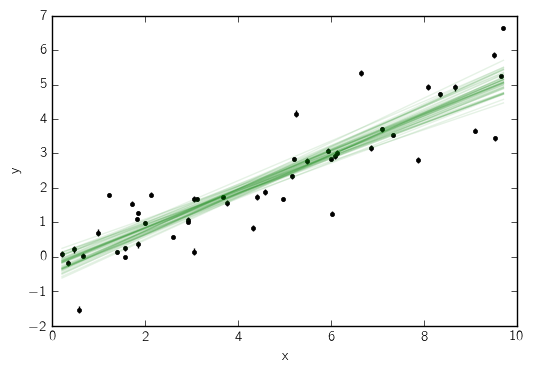

In [27]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

for i in np.random.randint(len(line_chain), size=50):
    m, b, _ = line_chain[i]
    plt.plot(x, m*x+b, "g", alpha=0.1)

plt.xlabel("x")
plt.ylabel("y");